In [1]:
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import pairwise
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
data_path = "../data/neurips-2023-data/de_per_donor.h5ad"

In [3]:
adata = ad.read_h5ad(data_path)

In [4]:
# add mse on the pseudobulk to the metrics
adata_pseudobulk = ad.read_h5ad("../data/neurips-2023-data/pseudobulk_cleaned.h5ad")

In [5]:
adata_pseudobulk.obs["sm_cell_type_donor"] = adata_pseudobulk.obs["sm_name"].astype(str) + "_" + adata_pseudobulk.obs["cell_type"].astype(str) + "_" + adata_pseudobulk.obs["donor_id"].astype(str)
adata_pseudobulk.obs.sm_cell_type_donor = adata_pseudobulk.obs.sm_cell_type_donor.astype("category")

In [6]:
# normalize by cell count
adata_pseudobulk.X = adata_pseudobulk.X / adata_pseudobulk.obs["cell_count_by_well_celltype"].values[:, None]

In [7]:
adata_pseudobulk.X = adata_pseudobulk.X.todense()

In [8]:
X_df = pd.DataFrame(adata_pseudobulk.X, index=adata_pseudobulk.obs.index, columns=adata_pseudobulk.var_names)
grouped_means = X_df.groupby(adata_pseudobulk.obs['sm_cell_type_donor']).mean()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_11673/3261264666.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_df.groupby(adata_pseudobulk.obs['sm_cell_type_donor']).mean()


In [9]:
adata.layers["log_counts"] = np.log1p(grouped_means.loc[adata.obs.sm_cell_type_donor].values)

In [10]:
def de_to_t_score(de):
    """Convert log10pvalues to t-scores
    
    Parameter:
    de: array or DataFrame of log10pvalues
    
    Return value:
    t_score: array or DataFrame of t-scores
    """
    p_value = 10 ** (-np.abs(de))
    return - norm.ppf(p_value / 2) * np.sign(de)

In [11]:
adata.layers['t_score'] = de_to_t_score(adata.layers['sign_log10_nonadj_pval'])

In [12]:
def calculate_mse(single_data, multiple_data):
    squared_diffs = (single_data - multiple_data) ** 2
    mse_results = np.mean(squared_diffs, axis=1)
    return np.expand_dims(mse_results, axis=0)

In [13]:
def calculate_mae(single_data, multiple_data):
    abs_diffs = np.abs(single_data - multiple_data)
    mae_results = np.mean(abs_diffs, axis=1)
    return np.expand_dims(mae_results, axis=0)

In [14]:
ranks = {
    'signature': [],
    'cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'sm_name': [],
    'rank_cosine': [],
    'rank_mae': [],
    'rank_mse': []
}

# Iterate over each layer (signature) to calculate cosine similarities
for signature in adata.layers.keys():
    print(f"Processing signature: {signature}")
    for cell_type in adata.obs['cell_type'].unique():
        # Filter data by sm_cell_type
        cell_type_adata = adata[adata.obs['cell_type'] == cell_type]
        sm_names = cell_type_adata.obs['sm_name'].unique()

        # Get unique donors within this sm_cell_type
        donors = cell_type_adata.obs['donor_id'].unique()

        # Iterate over all combinations of two different donors
        for donor_id_1, donor_id_2 in itertools.combinations(donors, 2):
            # Filter data for each donor
            donor_data_1 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_1]
            donor_data_2 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_2]
            
            for sm_name in donor_data_1.obs['sm_name'].unique():
                if sm_name not in donor_data_2.obs['sm_name'].unique():
                    continue
                # get index of sm_name in donor_data_2
                idx = np.where(donor_data_2.obs['sm_name'] == sm_name)[0][0]
                data1 = donor_data_1[donor_data_1.obs['sm_name'] == sm_name].layers[signature].astype(float)
                data2 = donor_data_2.layers[signature].astype(float)
                cosine_similarity = pairwise.cosine_similarity(
                    data1,
                    data2
                )
                # pairwise MAE
                mae = calculate_mae(data1, data2)
                mse = calculate_mse(data1, data2)
                rank_cosine = np.where(np.argsort(-cosine_similarity) == idx)[1][0]
                rank_mae = np.where(np.argsort(mae) == idx)[1][0]
                rank_mse = np.where(np.argsort(mse) == idx)[1][0]
                ranks['signature'].append(signature)
                ranks['cell_type'].append(cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['sm_name'].append(sm_name)
                ranks['rank_cosine'].append(rank_cosine)
                ranks['rank_mae'].append(rank_mae)
                ranks['rank_mse'].append(rank_mse)

# Convert ranks to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: P.Value
Processing signature: adj.P.Value
Processing signature: is_de
Processing signature: is_de_adj
Processing signature: logFC
Processing signature: sign_log10_nonadj_pval
Processing signature: sign_log10_pval
Processing signature: log_counts
Processing signature: t_score


Cosine sim

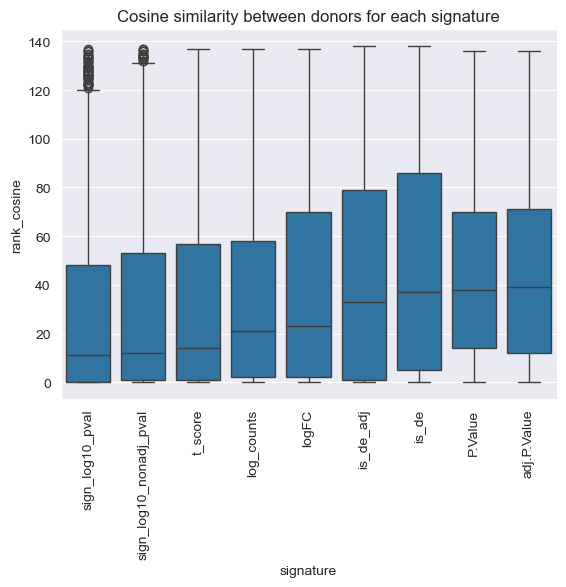

In [15]:
ordered_signatures = ranks_df.groupby('signature')['rank_cosine'].median().sort_values().index
sns.boxplot(data=ranks_df, x='signature', y='rank_cosine', order=ordered_signatures)
plt.xticks(rotation=90)
plt.title('Cosine similarity between donors for each signature')
plt.show()

MAE

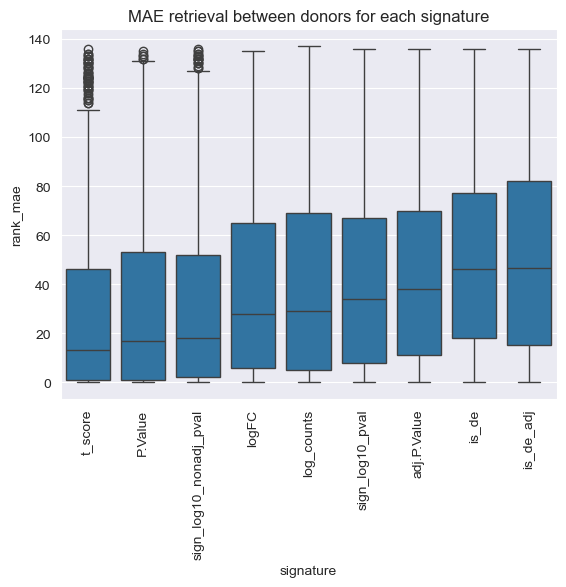

In [16]:
ordered_signatures = ranks_df.groupby('signature')['rank_mae'].median().sort_values().index
sns.boxplot(data=ranks_df, x='signature', y='rank_mae', order=ordered_signatures)
plt.xticks(rotation=90)
plt.title('MAE retrieval between donors for each signature')
plt.show()

MSE

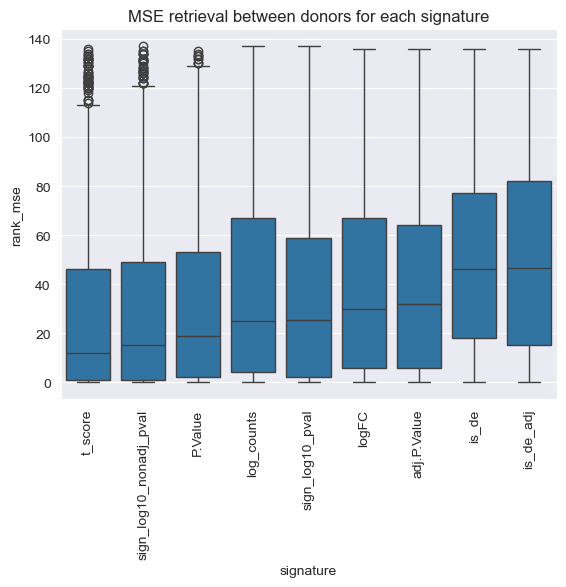

In [17]:
ordered_signatures = ranks_df.groupby('signature')['rank_mse'].median().sort_values().index
sns.boxplot(data=ranks_df, x='signature', y='rank_mse', order=ordered_signatures)
plt.xticks(rotation=90)
plt.title('MSE retrieval between donors for each signature')
plt.show()

In [105]:
ranks_subset = ranks_df[~ranks_df['signature'].isin(["t_score", "is_de_adj"])].copy()

In [106]:
rename_dict = {
    'P.Value': 'P-value',
    'adj.P.Value': 'Adjusted P-value',
    'is_de': 'Differentially expressed (<0.05)',
    'logFC': 'Log fold-change',
    'sign_log10_nonadj_pval': 'sig log10(P-value)',
    'sign_log10_pval': 'sig log10(adj. P-value)',
    'log_counts': 'Log(counts + 1)'
}

In [107]:
ranks_subset.signature = ranks_subset.signature.astype("category").cat.rename_categories(rename_dict)

In [108]:
ranks_subset.rename(columns={"rank_mse": "Rank"}, inplace=True)

In [109]:
ranks_subset.rename(columns={"signature": "Signature"}, inplace=True)

In [110]:
sns.set_style("whitegrid")
sns.set_style("white")
# sns.diverging_palette(145, 300, s=60, as_cmap=True)

In [116]:
palette = sns.color_palette("colorblind")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_11673/3658966774.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_signatures = ranks_subset.groupby('Signature')['Rank'].median().sort_values().index


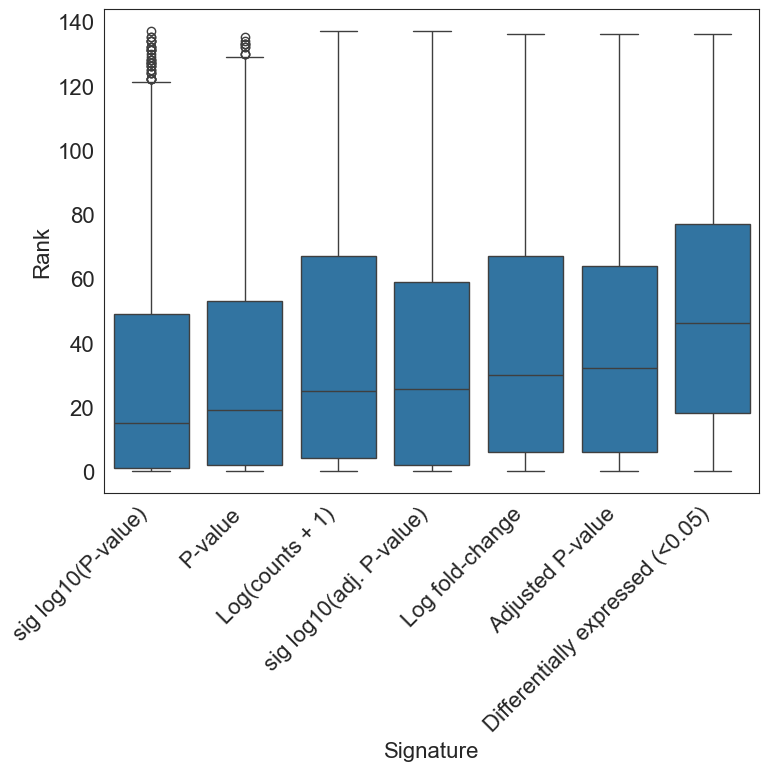

In [118]:
ordered_signatures = ranks_subset.groupby('Signature')['Rank'].median().sort_values().index
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
sns.boxplot(data=ranks_subset, x='Signature', y='Rank', order=ordered_signatures)
plt.xticks(rotation=45, ha='right')
#plt.title('MSE cross-donor retrieval each signature')
plt.tight_layout()
plt.savefig("mse_cross_donor_retrieval.svg")
plt.show()

In [65]:
ranks_subset.rename(columns={"Rank": "rank_mse"}, inplace=True)

In [87]:
palette = sns.color_palette("colorblind")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_11673/4279211857.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.boxplot(data=df_melted, x='Metric', y='Rank', hue='Signature', hue_order=ordered_signatures[:-2], palette=palette)


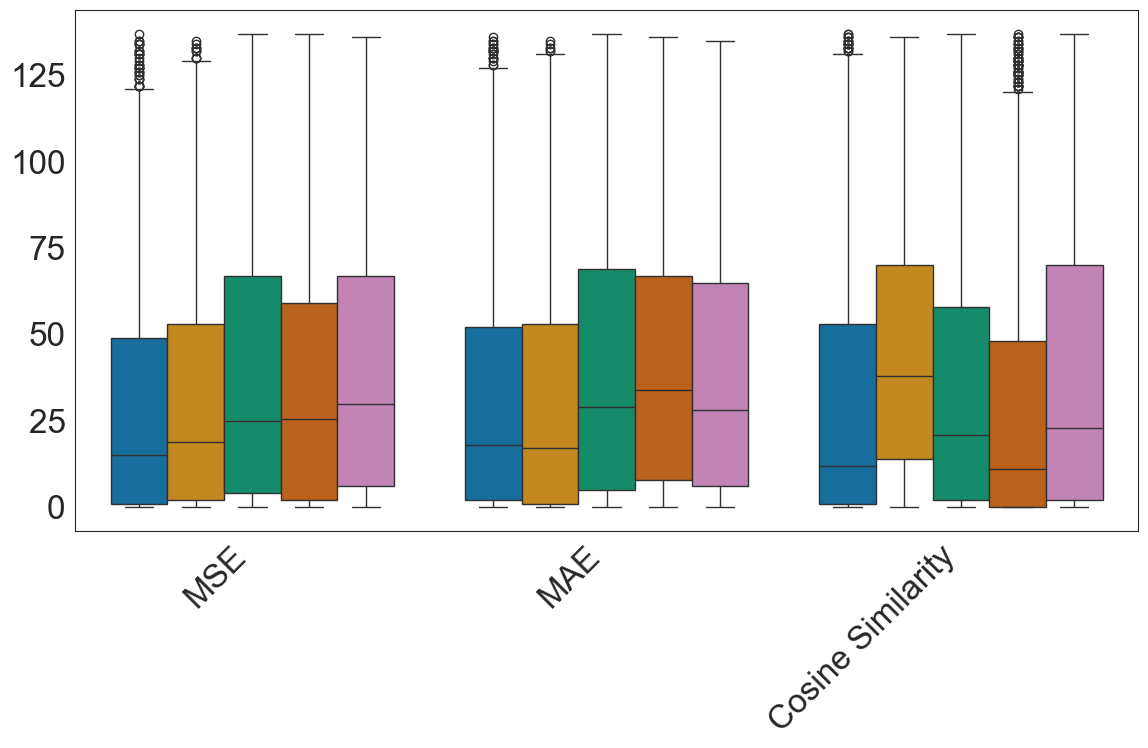

In [90]:
df_melted = ranks_subset.melt(id_vars=['Signature', 'cell_type', 'donor_id_1', 'donor_id_2', 'sm_name'], 
                    value_vars=['rank_mse', 'rank_mae', 'rank_cosine'],
                    var_name='Metric', value_name='Rank')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_melted, x='Metric', y='Rank', hue='Signature', hue_order=ordered_signatures[:-2], palette=palette)
labels = ['MSE', 'MAE', 'Cosine Similarity']
plt.xticks(rotation=45, ha='right', labels=labels, ticks=ax.get_xticks())
plt.legend(title='Signature', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("metrics_across_signatures.svg")
plt.show()

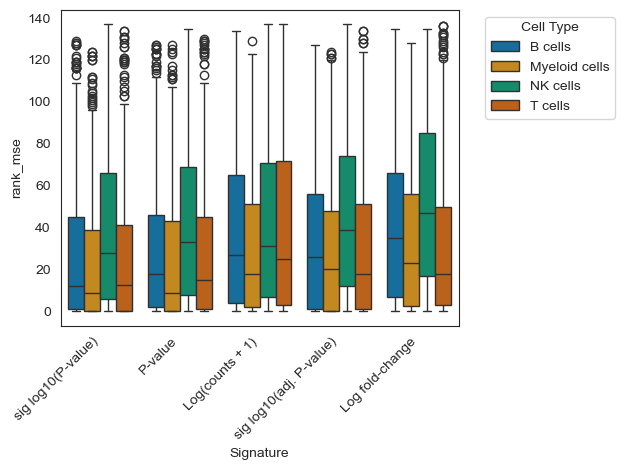

In [73]:
# same but per cell type, donor and sm_name
sns.boxplot(data=ranks_subset, x='Signature', y='rank_mse', hue='cell_type', order=ordered_signatures[:-2], palette=palette)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.title('MAE ranks between donors for each signature by cell type')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.xticks(rotation=45, ha='right')
#plt.title('MSE cross-donor retrieval each signature')
plt.tight_layout()
plt.savefig("retrieval_across_cell_types.svg")
plt.show()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_11673/2259966603.py:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.boxplot(data=df_melted, x='cell_type', y='Rank', hue='Signature', palette=palette, hue_order=ordered_signatures[:-2])


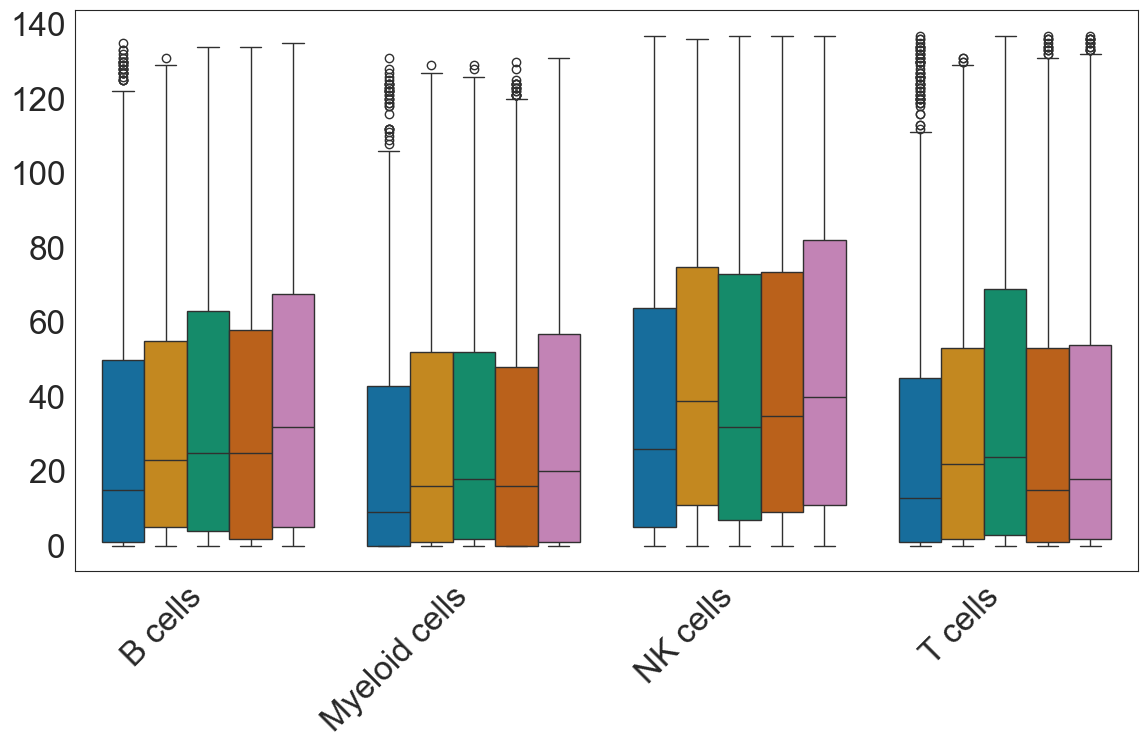

In [89]:
df_melted = ranks_subset.melt(id_vars=['Signature', 'cell_type', 'donor_id_1', 'donor_id_2', 'sm_name'], 
                    value_vars=['rank_cosine', 'rank_mae', 'rank_mse'],
                    var_name='Metric', value_name='Rank')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(12, 8))
# Plot using cell_type as x-axis and Signature as hue
ax = sns.boxplot(data=df_melted, x='cell_type', y='Rank', hue='Signature', palette=palette, hue_order=ordered_signatures[:-2])

# Optional: If you have many signatures, you might want to handle the legend better
plt.legend(title='Signature', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()
plt.xticks(rotation=45, ha='right')

# Adjust layout to make room for the rotated x-axis labels and legend
plt.tight_layout()

# Save the plot
plt.savefig("boxplot_across_cell_types_by_signature.svg")

# Display the plot
plt.show()

In [188]:
ranks_df_subset = ranks_df[ranks_df['signature'].isin(['sign_log10_pval_clipped_0001'])].copy()

In [189]:
ordered_signatures = ranks_df_subset.groupby('sm_name')['rank'].median().sort_values().index

In [191]:
adata_df = pd.DataFrame(adata.layers['adj.P.Value'], columns=adata.var_names)
adata_df['sm_name'] = adata.obs['sm_name'].values  # Add 'sm_name' from .obs to the DataFrame

# Step 2: Group by 'sm_name' and sum the 'sign_log10_pval'
grouped_sum = adata_df.groupby('sm_name').mean()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_4694/2862755947.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = adata_df.groupby('sm_name').mean()


In [192]:
sum_sign_log10_pval = grouped_sum.mean(axis=1)
sm_name_to_sum_pval = sum_sign_log10_pval.to_dict()

In [193]:
ranks_df_subset["sum_pval"] = ranks_df_subset["sm_name"].map(lambda x: sm_name_to_sum_pval[x])

In [194]:
ranks_df_subset["median_rank"] = ranks_df_subset["sm_name"].map(ranks_df_subset.groupby('sm_name')['rank'].median().to_dict())

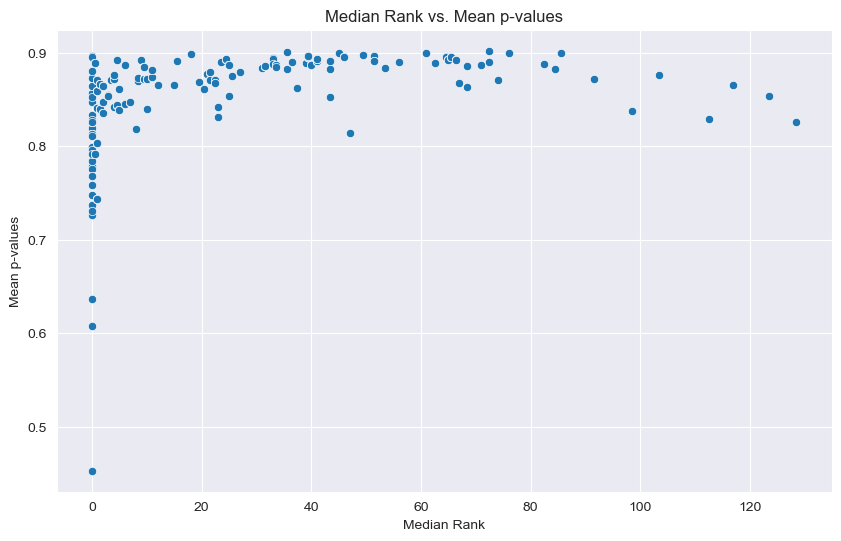

In [195]:
df_sorted = ranks_df_subset.sort_values('median_rank')

# Step 2: Create the plot using seaborn
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
ax = sns.scatterplot(data=df_sorted, x='median_rank', y='sum_pval')

# Optional: Customize the plot
plt.title('Median Rank vs. Mean p-values')
plt.xlabel('Median Rank')
plt.ylabel('Mean p-values')
# ax.set_xscale('log')
# ax.set_yscale('log')

# Show the plot
plt.show()

In [196]:
df_sorted[df_sorted.sum_pval < 0.8].sm_name.unique()

array(['Proscillaridin A;Proscillaridin-A', 'Pitavastatin Calcium',
       'Resminostat', 'Doxorubicin', 'Colchicine', 'Scriptaid',
       'BAY 61-3606', 'LY2090314', 'IN1451', 'I-BET151', 'Belinostat',
       'Dactolisib', 'Dabrafenib', 'Ganetespib (STA-9090)', 'IMD-0354',
       'AT13387', 'Mometasone Furoate', 'Vorinostat'], dtype=object)

In [139]:
# group molecules by signature

In [146]:
de_train_path = "../data/neurips-2023-data/de_train.h5ad"
de_test_path = "../data/neurips-2023-data/de_test.h5ad"

In [147]:
adata_train = ad.read_h5ad(de_train_path)
adata_test = ad.read_h5ad(de_test_path)

In [151]:
import scanpy as sc

In [152]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [161]:
moa_annotations = pd.read_csv("../data/complete_data/moa_annotations.csv")

In [162]:
adata_train.obs["moa_annotations"] = adata_train.obs["sm_name"].map(moa_annotations.set_index("sm_name")["moa"])

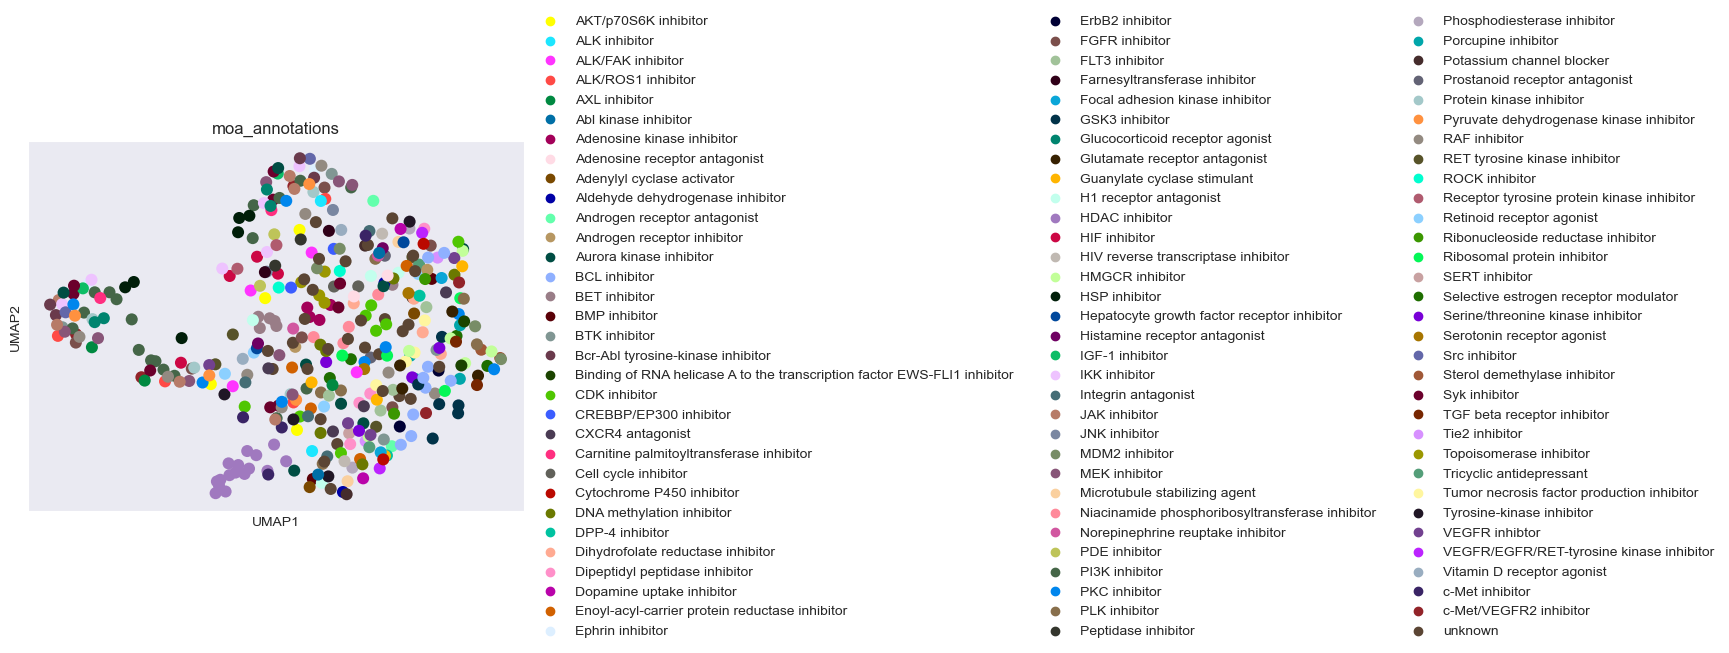

In [170]:
sc.pl.umap(adata_train, color="moa_annotations")

In [168]:
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)

         Falling back to preprocessing with `sc.pp.pca` and default params.


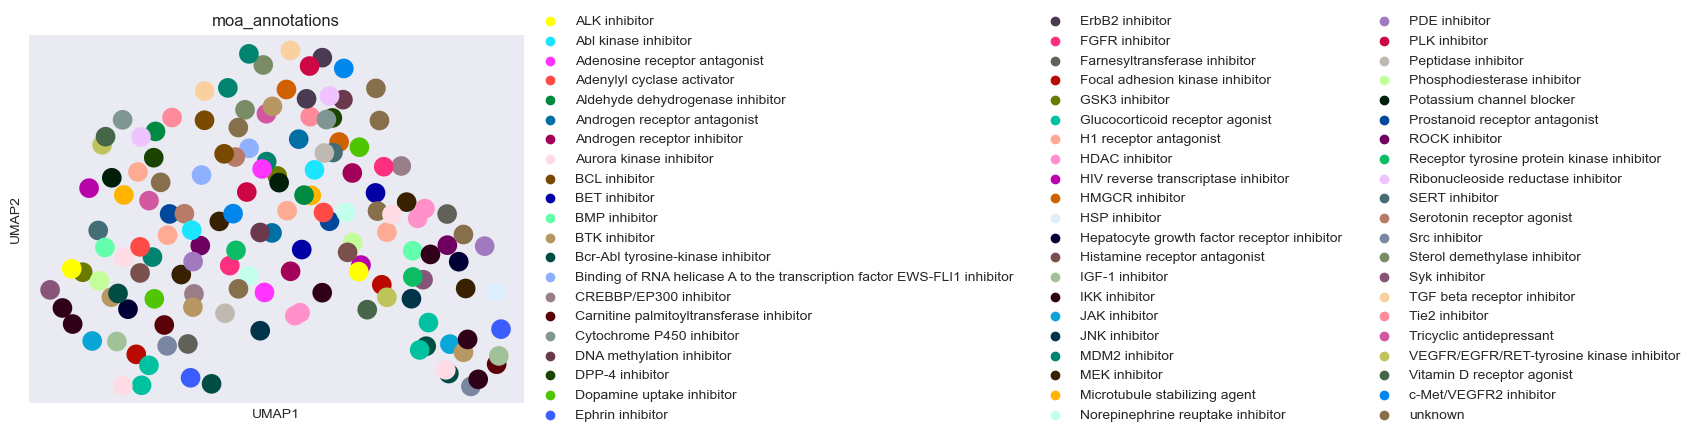

In [171]:
adata_test.obs["moa_annotations"] = adata_test.obs["sm_name"].map(moa_annotations.set_index("sm_name")["moa"])
sc.pl.umap(adata_test, color="moa_annotations")

In [203]:
adata_new = ad.read_h5ad("../data/neurips-2023-data/de_train.h5ad")

In [204]:
pseudobulk_new = ad.read_h5ad("../data/neurips-2023-data/pseudobulk_cleaned.h5ad")

In [205]:
pseudobulk_new = pseudobulk_new[(pseudobulk_new.obs.split == "train") | (pseudobulk_new.obs.split == "control")]

In [206]:
zero_genes = {}
pseudobulk_dmso = pseudobulk_new[pseudobulk_new.obs.sm_name == 'Dimethyl Sulfoxide']
for cell_type in pseudobulk_dmso.obs.cell_type.unique():
    zero_genes[cell_type] = pseudobulk_dmso[:, pseudobulk_dmso[pseudobulk_dmso.obs.cell_type == cell_type].X.sum(axis=0) == 0].var_names.tolist()

In [207]:
len(zero_genes)

4

In [181]:
# illustrate the issue of low p-values despite no change in counts
kaggle_path = "../data/neurips-2023-kaggle/2023-09-12_de_by_cell_type_train.h5ad"
adata_kaggle = ad.read_h5ad(kaggle_path)

In [182]:
pseudobulk = ad.read_h5ad("../data/neurips-2023-kaggle/pseudobulk.h5ad")

In [183]:
pseudobulk = pseudobulk[(pseudobulk.obs.split == "train") | (pseudobulk.obs.split == "control")]

In [184]:
pseudobulk = pseudobulk[:, adata_kaggle.var_names]

In [185]:
pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_name"].astype(str) + pseudobulk.obs["cell_type"].astype(str)
pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_celltype"].astype("category")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_10139/162728329.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_name"].astype(str) + pseudobulk.obs["cell_type"].astype(str)


In [198]:
# find zero celltype-gene combinations
zero_genes = {}

In [199]:
pseudobulk_dmso = pseudobulk[pseudobulk.obs.sm_name == 'Dimethyl Sulfoxide']

In [200]:
for cell_type in pseudobulk_dmso.obs.cell_type.unique():
    zero_genes[cell_type] = pseudobulk_dmso[:, pseudobulk_dmso[pseudobulk_dmso.obs.cell_type == cell_type].X.sum(axis=0) == 0].var_names.tolist()

In [201]:
len(zero_genes)

6

In [189]:
zero_genes_other = {}

In [ ]:
for sm_celltype in pseudobulk.obs.sm_celltype.unique():
    cur_adata = pseudobulk[pseudobulk.obs.sm_celltype == sm_celltype]
    cur_celltype = cur_adata.obs.cell_type.values[0]
    zero_genes_dmso = zero_genes[cur_celltype]
    zero_genes_cur = cur_adata[:, cur_adata.X == 0].var_names.tolist()
    zero_genes_cur = set(zero_genes_cur).intersection(zero_genes_dmso)
    if len(zero_genes_cur) > 0:
        zero_genes_other[sm_celltype] = zero_genes_cur

In [193]:
len(zero_genes_other)

620

In [191]:
# there are 620 drug-cell type combindations that have zero counts in both, the drug and the control

In [192]:
adata_kaggle.obs["sm_celltype"] = adata_kaggle.obs["sm_name"].astype(str) + adata_kaggle.obs["cell_type"].astype(str)
adata_kaggle.obs["sm_celltype"] = adata_kaggle.obs["sm_celltype"].astype("category")

In [155]:
small_pvals = {}

In [156]:
for sm_celltype in zero_genes_other.keys():
    if sm_celltype not in adata_kaggle.obs.sm_celltype.unique():
        continue
    # check p-values
    cur_adata = adata_kaggle[adata_kaggle.obs.sm_celltype == sm_celltype, list(zero_genes_other[sm_celltype])]
    cur_pvals = cur_adata.layers["P.Value"]
    genes_with_small_pvals = cur_adata[:, cur_pvals < 0.05].var_names
    if len(genes_with_small_pvals) > 0:
        small_pvals[sm_celltype] = genes_with_small_pvals

In [157]:
len(small_pvals)

145

In [158]:
# calculate the number of genes with small p-values
total_small_pvals = 0
for sm_celltype in small_pvals.keys():
    total_small_pvals += len(small_pvals[sm_celltype])

In [159]:
total_small_pvals

99713

In [109]:
ranks_df.to_csv("../data/cross_donor_retrieval_ranks_df.csv")